In [1]:
### Imports and metadata ###

import os
import sys
import time
import glob
import numpy as np
import tensorflow as tf 
from keras import backend as K
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import *
import visualize
from classifier import get_classifier
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from functools import reduce

Using TensorFlow backend.


In [2]:
### Load data ###

data_path = 'data'
files = glob.glob(os.path.join(data_path, '*.csv'))
datasets = [np.genfromtxt(file, delimiter=',') for file in files]
labels = np.concatenate([[i]*len(ds) for i,ds in enumerate(datasets)], axis=0)
data = np.concatenate(datasets, axis=0)

# center all wrist positions to 0,0
data = data - np.expand_dims(data[:,0],axis=-1)

# normalize
data /= np.max(data)

# add cluster labels 
data_labeled = np.concatenate((data, np.expand_dims(labels, axis=1)), axis=-1)

In [3]:
### Load models ###

basic_enc = load_model('models/basic_enc.h5')
basic_dec = load_model('models/basic_dec.h5')
basic_svm = get_classifier(basic_enc, data, labels)

tsne_enc = load_model('models/tsne_enc.h5')
tsne_dec = load_model('models/tsne_dec.h5')
tsne_svm = get_classifier(tsne_enc, data, labels)

var_enc = load_model('models/variational_enc.h5')
var_dec = load_model('models/variational_dec.h5')
var_svm = get_classifier(var_enc, data, labels)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
def benchmark_task(enc, dec, svm, hand, var=False):
    start_time = time.time()
    
    enc_hand = enc.predict(np.expand_dims(hand, axis=0))
    if var:
        enc_hand = enc_hand[0]
    classification = svm.predict(enc_hand)
    dec_hand = dec.predict(enc_hand)
    
    end_time = time.time()
    return end_time - start_time

arches = [(basic_enc, basic_dec, basic_svm), (tsne_enc, tsne_dec, tsne_svm), (var_enc, var_dec, var_svm)]
for a, arch in enumerate(arches):
    print('starting arch {}'.format(a))
    times = np.zeros((len(data),))
    for i, hand in enumerate(data):
        time_elapsed = benchmark_task(*arch, hand, var=(a==2))
        times[i] = time_elapsed
    np.save('benchmark_data/{}.npy'.format(a), times)

starting arch 0
starting arch 1
starting arch 2


average basic: 0.0011803451264522855
average tsne: 0.0012673719822546912
average var: 0.0023572399900434666
median basic: 0.0011603832244873047
median tsne: 0.0012369155883789062
median var: 0.002283811569213867
std basic: 0.00016997145468572472
std tsne: 0.0001921520952039676
std var: 0.0005274763601886353
max basic: 0.013906002044677734
max tsne: 0.00857996940612793
max var: 0.07934904098510742
min basic: 0.0009560585021972656
min tsne: 0.0010249614715576172
min var: 0.0019991397857666016


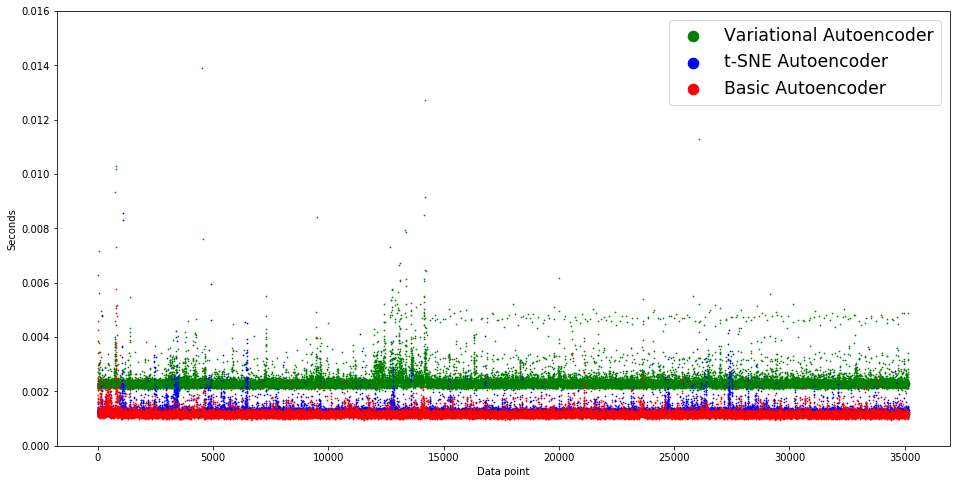

In [34]:
basic_times = np.load('benchmark_data/0.npy')
tsne_times = np.load('benchmark_data/1.npy')
var_times = np.load('benchmark_data/2.npy')

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.scatter(range(len(var_times)),   var_times,   c='g', s=0.5, label='Variational Autoencoder')
ax.scatter(range(len(tsne_times)),  tsne_times,  c='b', s=0.5, label='t-SNE Autoencoder')
ax.scatter(range(len(basic_times)), basic_times, c='r', s=0.5, label='Basic Autoencoder')
ax.set_ylim((0,0.016))
ax.legend(fontsize='xx-large', markerscale=15)
ax.set_ylabel('Seconds')
ax.set_xlabel('Data point')

print('average basic: {}'.format(np.average(basic_times)))
print('average tsne: {}'.format(np.average(tsne_times)))
print('average var: {}'.format(np.average(var_times)))

print('median basic: {}'.format(np.median(basic_times)))
print('median tsne: {}'.format(np.median(tsne_times)))
print('median var: {}'.format(np.median(var_times)))

print('std basic: {}'.format(np.std(basic_times)))
print('std tsne: {}'.format(np.std(tsne_times)))
print('std var: {}'.format(np.std(var_times)))

print('max basic: {}'.format(np.max(basic_times)))
print('max tsne: {}'.format(np.max(tsne_times)))
print('max var: {}'.format(np.max(var_times)))

print('min basic: {}'.format(np.min(basic_times)))
print('min tsne: {}'.format(np.min(tsne_times)))
print('min var: {}'.format(np.min(var_times)))

In [54]:
# property 3 benchmark
permutation_amount = 0.01
num_permutations = 10000

enc_basic = basic_enc.predict(data)
prev_point = enc_basic[np.random.choice(len(enc_basic))]
prev_hand = basic_dec.predict(np.expand_dims(start_point, axis=0))
perm_mses = []

for i in range(num_permutations):
    new_point = prev_point + np.random.normal(scale=permutation_amount, size=prev_point.shape)
    new_hand = basic_dec.predict(np.expand_dims(new_point, axis=0))
    
    mse = ((new_hand - prev_hand)**2).mean()
    perm_mses.append(mse)
    
    prev_point = new_point
    prev_hand = new_hand
    
# do it randomly
prev_point = enc_basic[np.random.choice(len(enc_basic))]
prev_hand = basic_dec.predict(np.expand_dims(start_point, axis=0))
rand_mses = []

for i in range(num_permutations):
    new_point = enc_basic[np.random.choice(len(enc_basic))]
    new_hand = basic_dec.predict(np.expand_dims(new_point, axis=0))
    
    mse = ((new_hand - prev_hand)**2).mean()
    rand_mses.append(mse)
    
    prev_point = new_point
    prev_hand = new_hand

Text(0.5, 0, 'Log(mean squared error)')

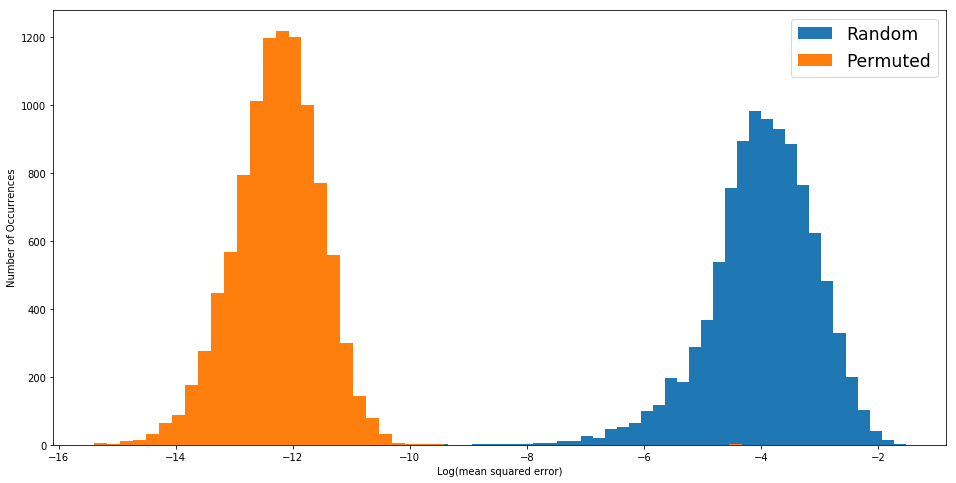

In [60]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.hist(np.log(rand_mses), bins=50, label='Random')
ax.hist(np.log(perm_mses), bins=50, label='Permuted')
ax.legend(fontsize='xx-large', markerscale=15)
ax.set_ylabel('Number of Occurrences')
ax.set_xlabel('Log(mean squared error)')

In [72]:
# measure property 4
num_runs = 10000

same_gesture_distances = []
for i in range(num_runs):
    # select a random gesture, and select two hands from that gesture 
    gesture = np.random.choice(5)
    data_gesture = data[labels==gesture]
    
    h1 = basic_enc.predict(np.expand_dims(data_gesture[np.random.choice(len(data_gesture))], axis=0))
    h2 = basic_enc.predict(np.expand_dims(data_gesture[np.random.choice(len(data_gesture))], axis=0))
    
    distance = np.linalg.norm(h1-h2)
    same_gesture_distances.append(distance)
    
different_gesture_distances = []
for i in range(num_runs):
    g1 = np.random.choice(5)
    g2 = np.random.choice(5)
    # make sure they're different 
    while g1 == g2:
        g2 = np.random.choice(5)
        
    data_g1 = data[labels==g1]
    data_g2 = data[labels==g2]
    
    h1 = basic_enc.predict(np.expand_dims(data_g1[np.random.choice(len(data_g1))], axis=0))
    h2 = basic_enc.predict(np.expand_dims(data_g2[np.random.choice(len(data_g2))], axis=0))
    
    distance = np.linalg.norm(h1-h2)
    different_gesture_distances.append(distance)

Text(0, 0.5, 'Number of occurrences')

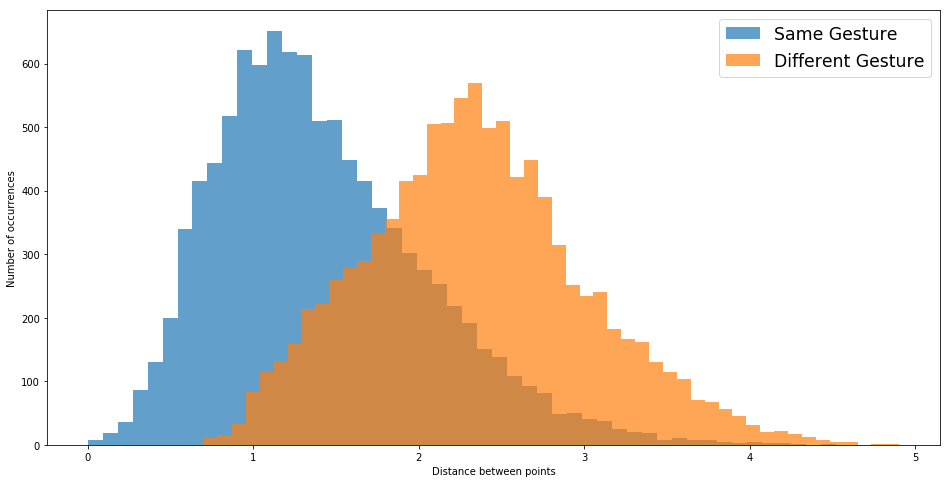

In [78]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.hist(same_gesture_distances,      bins=50, alpha=0.7, label='Same Gesture')
ax.hist(different_gesture_distances, bins=50, alpha=0.7, label='Different Gesture')
ax.legend(fontsize='xx-large', markerscale=15)
ax.set_xlabel('Distance between points')
ax.set_ylabel('Number of occurrences')